In [1]:
%matplotlib inline

# Model Building Part 1

Code for building the models  
_Author: Jimmy Charité_  
_Email: jimmy.charite@gmail.com_  

In model building part one, I experiment with the performance of models that ignore 'bag of word' type features. Several of the classes defined in this notebook will not be used. I keep them here for use in later model building exercises. 

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
retval=os.chdir("..")

In [4]:
clean_data=pd.read_pickle('./clean_data/clean_data.pkl')

In [5]:
clean_data.head()

,helpful,num_sents,num_words,readability,neg_senti,pos_senti,neu_senti,comp_senti,text_lemma,vec0,...,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,0.0,0.693147,3.610918,6.742881,0.079,0.068,0.853,-0.1027,product arrive label peanut actually small siz...,0.033346,...,-0.023125,-0.005069,0.007344,-0.045929,-0.017832,-0.018206,-0.017281,0.012410,0.020198,-0.002511
1,0.0,1.386294,3.555348,6.734948,0.000,0.448,0.552,0.9468,great taffy great price wide assortment yummy ...,0.037825,...,-0.015524,0.009058,0.020853,-0.058746,-0.001076,-0.013715,-0.035464,0.006317,0.023066,0.012566
2,0.0,1.609438,4.499810,6.743588,0.029,0.163,0.809,0.8830,get wild hair taffy order pound bag taffy enjo...,0.039023,...,-0.011637,0.008717,0.007918,-0.046595,-0.012542,-0.028316,-0.036677,0.015261,0.016227,0.008930
3,0.0,1.609438,4.143135,6.742527,0.034,0.273,0.693,0.9346,saltwater taffy great flavor soft chewy candy ...,0.038912,...,-0.010440,0.006156,0.007695,-0.039642,-0.012080,-0.026868,-0.018743,0.009134,0.021543,0.016047
4,0.0,1.609438,3.526361,6.737915,0.000,0.480,0.520,0.9487,taffy good soft chewy flavor amazing definitel...,0.043776,...,-0.010004,-0.003239,0.014308,-0.050601,-0.024100,-0.023046,-0.017151,0.017009,0.010729,0.004194


In [6]:
kept_cols=['helpful', 'num_sents', 'num_words', 'readability', 'neg_senti',
       'pos_senti', 'neu_senti', 'comp_senti']

## Training and Testing Split

In [7]:
my_rand_state=0
test_size=0.25

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = (clean_data[kept_cols].iloc[:,1:]).as_matrix()
y = (clean_data[kept_cols].iloc[:,0]).tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                              random_state=my_rand_state)

## Feature Selection

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
vt = VarianceThreshold()
threshold=[p*(1-p) for p in [0, 0.05, 0.1, 0.15]]

Note, since the formula for the variance of binary variables is p*(1-p), where p is the proportion of times that the binary variable is 1, I use the proportion to define the variance thresholds. The max variance is 0.25 at p=0.5.

## Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

In [18]:
std_scale=StandardScaler()

## Classification Models

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Although tuning is not necessary for Naive Bayes, I pass the default parameters of those models to GridSearchCV anyway so that I can do a direct pair-wise comparison with the other models across the different steps of cross-validation.  

In the interest of time, I didn't use the SVM classifier.

In [23]:
nb_clf=GaussianNB()
priors=[None]

In [24]:
qda_clf=QuadraticDiscriminantAnalysis()
reg_param=[0.0, 0.25, 0.5, 0.75]

In [25]:
log_clf=LogisticRegression(penalty='l2')
C=[0.001 , 0.01, 10, 100,1000]

In [26]:
knn_clf=KNeighborsClassifier(n_jobs=4)
n_neighbors=[2,3,4,5,6,7]
weights=['uniform','distance']

In [27]:
rf_clf=RandomForestClassifier()
n_estimators=[100,200]
max_features=[.1,.3,.5]

In [28]:
dtree=DecisionTreeClassifier(max_depth=None, min_samples_split=2)
bagTree_clf=BaggingClassifier(base_estimator=dtree)
max_samples=[.3,.6]

In [29]:
class_weight=['balanced']
class_weight.extend([{1: w} for w in [1, 2, 10]])

## Creating Pipelines

In [30]:
from imblearn import pipeline #needed if mixing imblearn with sklearn classes
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

I plan on using imblearn classes for later iterations so I use it's pipeline in the beginning for convenience

In [31]:
n_jobs=4

In [32]:
n_folds=10
skfold = StratifiedKFold(n_splits=n_folds,random_state=my_rand_state, shuffle=False)

#### Naive Bayes Estimators

In [33]:
nb_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',nb_clf)])
nb_clf_est_b = GridSearchCV(estimator=nb_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__priors=priors))

#### QDA Estimators

In [34]:
qda_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',qda_clf)])
qda_clf_est_b = GridSearchCV(estimator=qda_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__reg_param=reg_param))

#### Logistic Estimators

In [35]:
log_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',log_clf)])
log_clf_est_b = GridSearchCV(estimator=log_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

#### KNN Estimators

In [36]:
knn_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',knn_clf)])
knn_clf_est_b = GridSearchCV(estimator=knn_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

#### Random Forest Estimators

In [37]:
rf_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',rf_clf)])
rf_clf_est_b = GridSearchCV(estimator=rf_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

#### Bagged Estimators

In [48]:
bagTree_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',bagTree_clf)])
bagTree_clf_est_b = GridSearchCV(estimator=bagTree_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__n_estimators=n_estimators,
              clf__max_samples=max_samples,
              clf__max_features=[len(X_train[0,])]))

## Fitting Estimators

In [39]:
from sklearn.externals import joblib

Basic Estimators: no bag of words or PCA

In [38]:
nb_clf_est_b.fit(X_train,y_train)
joblib.dump(nb_clf_est_b, './other_output/nb_clf_est_b.pkl')

['./other_output/nb_clf_est_b.pkl']

In [39]:
qda_clf_est_b.fit(X_train,y_train)
joblib.dump(qda_clf_est_b, './other_output/qda_clf_est_b.pkl')

['./other_output/qda_clf_est_b.pkl']

In [40]:
log_clf_est_b.fit(X_train,y_train)
joblib.dump(log_clf_est_b, './other_output/log_clf_est_b.pkl')

['./other_output/log_clf_est_b.pkl']

In [41]:
knn_clf_est_b.fit(X_train,y_train)
joblib.dump(knn_clf_est_b, './other_output/knn_clf_est_b.pkl')

['./other_output/knn_clf_est_b.pkl']

In [42]:
rf_clf_est_b.fit(X_train,y_train)
joblib.dump(rf_clf_est_b, './other_output/rf_clf_est_b.pkl')

['./other_output/rf_clf_est_b.pkl']

In [49]:
bagTree_clf_est_b.fit(X_train,y_train)
joblib.dump(bagTree_clf_est_b, './other_output/bagTree_clf_est_b.pkl')

['./other_output/bagTree_clf_est_b.pkl']

## Testing Estimators

In [50]:
from sklearn.metrics import roc_curve, auc

In [51]:
nb_clf_est_b=joblib.load('./other_output/nb_clf_est_b.pkl')
qda_clf_est_b=joblib.load('./other_output/qda_clf_est_b.pkl')
log_clf_est_b=joblib.load('./other_output/log_clf_est_b.pkl')
knn_clf_est_b=joblib.load('./other_output/knn_clf_est_b.pkl')
rf_clf_est_b=joblib.load('./other_output/rf_clf_est_b.pkl')
bagTree_clf_est_b=joblib.load('./other_output/bagTree_clf_est_b.pkl')

Basic Estimators: no bag of words or PCA

In [52]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_b.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_b.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_b.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_b.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_b.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

bagTree_fpr, bagTree_tpr, _ = roc_curve(y_test, 
                    bagTree_clf_est_b.predict_proba(X_test)[:,1])
bagTree_roc_auc = auc(bagTree_fpr, bagTree_tpr)

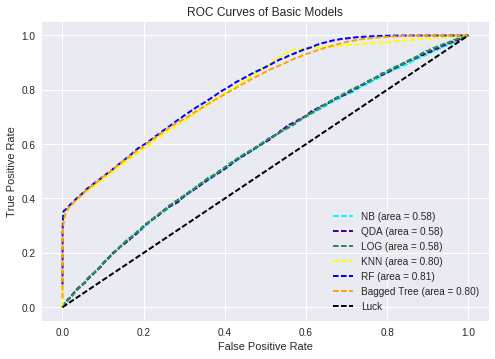

In [53]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot(bagTree_fpr, bagTree_tpr, color='orange', linestyle='--',
         label='Bagged Tree (area = %0.2f)' % bagTree_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Basic Models')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Basic.png', bbox_inches='tight')
plt.show()